# XGBoost con SMOTE

**Obiettivo:** Bilanciare le classi usando SMOTE (Synthetic Minority Oversampling Technique)

**Dataset:** Processed v3

**SMOTE:** Genera sample sintetici per la classe minoritaria interpolando tra esempi esistenti

**Pipeline:**
1. Caricamento dati
2. Applicazione SMOTE sul training set
3. Training XGBoost su dati bilanciati
4. Valutazione e confronto con baseline

## 1. Setup

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

print("Librerie importate!")
print(f"SMOTE version: {__import__('imblearn').__version__}")

Librerie importate!
SMOTE version: 0.14.0


## 2. Caricamento Dati

In [40]:
print("Caricamento dataset processed_v3...\n")

X_train = pd.read_csv('../data/processed_v3_balanced/X_train.csv')
X_test = pd.read_csv('../data/processed_v3_balanced/X_test.csv')
y_train = pd.read_csv('../data/processed_v3_balanced/y_train.csv')['BinaryIncidentGrade']
y_test = pd.read_csv('../data/processed_v3_balanced/y_test.csv')['BinaryIncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

print(f"\n{'='*50}")
print("DISTRIBUZIONE ORIGINALE (Training Set)")
print(f"{'='*50}")
class_counts = y_train.value_counts()
print(f"Classe 0 (Non-TP): {class_counts[0]:,} ({class_counts[0]/len(y_train)*100:.2f}%)")
print(f"Classe 1 (TP):     {class_counts[1]:,} ({class_counts[1]/len(y_train)*100:.2f}%)")
print(f"Imbalance ratio:   {class_counts[0]/class_counts[1]:.2f}:1")

Caricamento dataset processed_v3...

X_train: (348918, 43)
X_test: (149537, 43)

DISTRIBUZIONE ORIGINALE (Training Set)
Classe 0 (Non-TP): 247,302 (70.88%)
Classe 1 (TP):     101,616 (29.12%)
Imbalance ratio:   2.43:1


## 3. Applicazione SMOTE e UnderSampling

In [41]:
from imblearn.under_sampling import RandomUnderSampler

print("\nApplicazione RandomUnderSampler...\n")

# Calcola target samples per ratio 1.5:1
n_minority = (y_train == 1).sum()  # TP count
n_majority_target = int(n_minority * 1.5)  # 1.5x i TP

# sampling_strategy come dizionario: {classe: n_samples}
sampling_strategy = {0: n_majority_target}  # Riduci classe 0 (Non-TP)

print(f"Target samples - Classe 0: {n_majority_target:,} (ratio 1.5:1)")

rus = RandomUnderSampler(
    sampling_strategy=sampling_strategy,
    random_state=42
)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("Applicazione SMOTE...\n")

# SMOTE con sampling_strategy='auto' bilancia completamente le classi (50/50)
# Puoi usare sampling_strategy=0.5 per ratio 2:1 invece di 1:1
smote = SMOTE(
    sampling_strategy=0.8,
    random_state=42,
    k_neighbors=5
)

X_train_smote, y_train_smote = smote.fit_resample(X_train_resampled, y_train_resampled)

print(f"{'='*50}")
print("DOPO SMOTE")
print(f"{'='*50}")
print(f"X_train_smote: {X_train_smote.shape}")
class_counts_smote = pd.Series(y_train_smote).value_counts()
print(f"Classe 0 (Non-TP): {class_counts_smote[0]:,} ({class_counts_smote[0]/len(y_train_smote)*100:.2f}%)")
print(f"Classe 1 (TP):     {class_counts_smote[1]:,} ({class_counts_smote[1]/len(y_train_smote)*100:.2f}%)")
print(f"\n✅ Generati {class_counts_smote[1] - class_counts[1]:,} sample sintetici per classe minoritaria")


Applicazione RandomUnderSampler...

Target samples - Classe 0: 152,424 (ratio 1.5:1)
Applicazione SMOTE...

DOPO SMOTE
X_train_smote: (274363, 43)
Classe 0 (Non-TP): 152,424 (55.56%)
Classe 1 (TP):     121,939 (44.44%)

✅ Generati 20,323 sample sintetici per classe minoritaria


## 4. Visualizzazione Distribuzione Classi

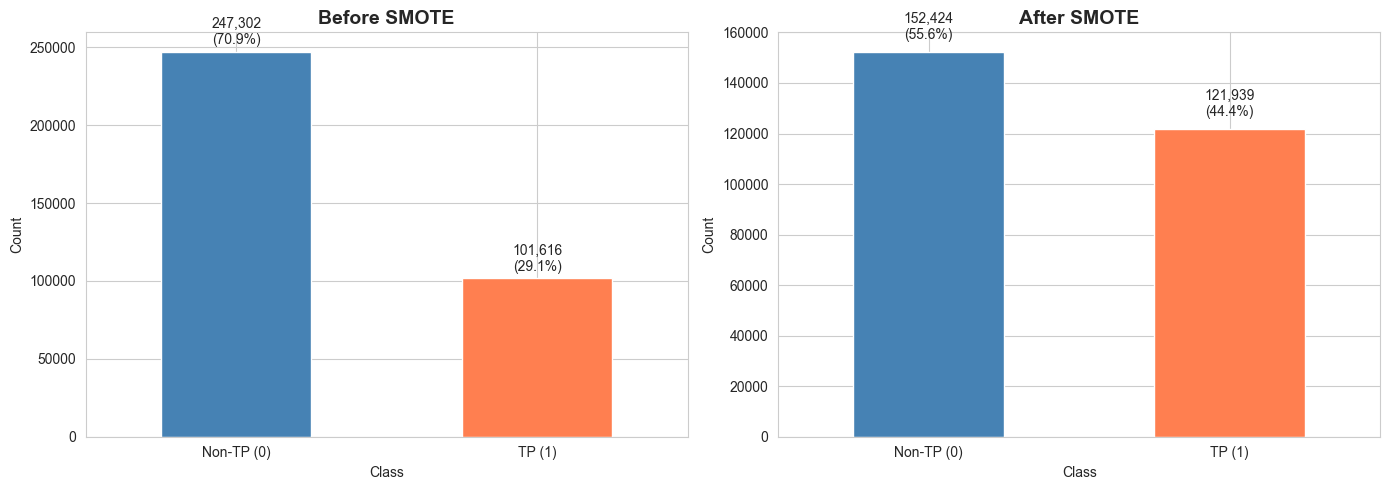

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
class_counts.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-TP (0)', 'TP (1)'], rotation=0)
for i, v in enumerate(class_counts):
    axes[0].text(i, v + 5000, f'{v:,}\n({v/len(y_train)*100:.1f}%)', ha='center')

# After SMOTE
class_counts_smote.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-TP (0)', 'TP (1)'], rotation=0)
for i, v in enumerate(class_counts_smote):
    axes[1].text(i, v + 5000, f'{v:,}\n({v/len(y_train_smote)*100:.1f}%)', ha='center')

plt.tight_layout()
plt.show()

## 5. Training XGBoost con dati SMOTE

In [43]:
print("Training XGBoost su dati bilanciati con SMOTE...\n")

# Nessun scale_pos_weight necessario, le classi sono bilanciate!
model_smote = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

model_smote.fit(
    X_train_smote, y_train_smote,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print("\n✅ Training completato!")

Training XGBoost su dati bilanciati con SMOTE...

[0]	validation_0-auc:0.88435
[1]	validation_0-auc:0.88591
[2]	validation_0-auc:0.90070
[3]	validation_0-auc:0.90783
[4]	validation_0-auc:0.91031
[5]	validation_0-auc:0.91165
[6]	validation_0-auc:0.91133
[7]	validation_0-auc:0.91224
[8]	validation_0-auc:0.91293
[9]	validation_0-auc:0.91313
[10]	validation_0-auc:0.91332
[11]	validation_0-auc:0.91413
[12]	validation_0-auc:0.91504
[13]	validation_0-auc:0.91548
[14]	validation_0-auc:0.91573
[15]	validation_0-auc:0.91605
[16]	validation_0-auc:0.91621
[17]	validation_0-auc:0.91656
[18]	validation_0-auc:0.91672
[19]	validation_0-auc:0.91670
[20]	validation_0-auc:0.91699
[21]	validation_0-auc:0.91701
[22]	validation_0-auc:0.91719
[23]	validation_0-auc:0.91764
[24]	validation_0-auc:0.91790
[25]	validation_0-auc:0.91806
[26]	validation_0-auc:0.91813
[27]	validation_0-auc:0.91821
[28]	validation_0-auc:0.91831
[29]	validation_0-auc:0.91835
[30]	validation_0-auc:0.91858
[31]	validation_0-auc:0.91868


## 6. Valutazione Performance

In [44]:
y_pred_smote = model_smote.predict(X_test)
y_pred_proba_smote = model_smote.predict_proba(X_test)[:, 1]

print("="*70)
print("PERFORMANCE TEST SET - XGBoost con SMOTE")
print("="*70)

print("\nClassification Report:")
print(classification_report(
    y_test, y_pred_smote,
    target_names=['Non-TP (0)', 'TruePositive (1)'],
    digits=4
))

precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)

print(f"\nPRECISION:         {precision_smote:.4f} ⭐")
print(f"RECALL:            {recall_smote:.4f}")
print(f"F1-SCORE:          {f1_smote:.4f}")
print(f"ROC AUC:           {roc_auc_smote:.4f}")

PERFORMANCE TEST SET - XGBoost con SMOTE

Classification Report:
                  precision    recall  f1-score   support

      Non-TP (0)     0.8962    0.9450    0.9200    105987
TruePositive (1)     0.8457    0.7336    0.7857     43550

        accuracy                         0.8835    149537
       macro avg     0.8710    0.8393    0.8528    149537
    weighted avg     0.8815    0.8835    0.8809    149537


PRECISION:         0.8457 ⭐
RECALL:            0.7336
F1-SCORE:          0.7857
ROC AUC:           0.9312


## 7. Confronto con Baseline (senza SMOTE)

In [45]:
print("Training modello baseline (senza SMOTE) per confronto...\n")

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_baseline = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

model_baseline.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred_baseline = model_baseline.predict(X_test)
y_pred_proba_baseline = model_baseline.predict_proba(X_test)[:, 1]

print("="*70)
print("PERFORMANCE TEST SET - Baseline (scale_pos_weight)")
print("="*70)

print("\nClassification Report:")
print(classification_report(
    y_test, y_pred_baseline,
    target_names=['Non-TP (0)', 'TruePositive (1)'],
    digits=4
))

precision_baseline = precision_score(y_test, y_pred_baseline)
recall_baseline = recall_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

print(f"\nPRECISION:         {precision_baseline:.4f}")
print(f"RECALL:            {recall_baseline:.4f}")
print(f"F1-SCORE:          {f1_baseline:.4f}")
print(f"ROC AUC:           {roc_auc_baseline:.4f}")

Training modello baseline (senza SMOTE) per confronto...

PERFORMANCE TEST SET - Baseline (scale_pos_weight)

Classification Report:
                  precision    recall  f1-score   support

      Non-TP (0)     0.9078    0.9176    0.9127    105987
TruePositive (1)     0.7940    0.7732    0.7835     43550

        accuracy                         0.8755    149537
       macro avg     0.8509    0.8454    0.8481    149537
    weighted avg     0.8747    0.8755    0.8750    149537


PRECISION:         0.7940
RECALL:            0.7732
F1-SCORE:          0.7835
ROC AUC:           0.9327


## 8. Tabella Comparativa

In [46]:
comparison = pd.DataFrame({
    'Model': ['Baseline (scale_pos_weight)', 'SMOTE'],
    'Training Samples': [len(X_train), len(X_train_smote)],
    'Precision': [precision_baseline, precision_smote],
    'Recall': [recall_baseline, recall_smote],
    'F1-Score': [f1_baseline, f1_smote],
    'ROC AUC': [roc_auc_baseline, roc_auc_smote]
})

print("\n" + "="*80)
print("CONFRONTO BASELINE vs SMOTE")
print("="*80)
print(comparison.to_string(index=False))

print("\n" + "="*80)
print("DELTA (SMOTE - Baseline)")
print("="*80)
print(f"Precision: {precision_smote - precision_baseline:+.4f} ({(precision_smote/precision_baseline-1)*100:+.2f}%)")
print(f"Recall:    {recall_smote - recall_baseline:+.4f} ({(recall_smote/recall_baseline-1)*100:+.2f}%)")
print(f"F1-Score:  {f1_smote - f1_baseline:+.4f} ({(f1_smote/f1_baseline-1)*100:+.2f}%)")
print(f"ROC AUC:   {roc_auc_smote - roc_auc_baseline:+.4f} ({(roc_auc_smote/roc_auc_baseline-1)*100:+.2f}%)")


CONFRONTO BASELINE vs SMOTE
                      Model  Training Samples  Precision   Recall  F1-Score  ROC AUC
Baseline (scale_pos_weight)            348918   0.793992 0.773226  0.783472 0.932677
                      SMOTE            274363   0.845730 0.733639  0.785707 0.931184

DELTA (SMOTE - Baseline)
Precision: +0.0517 (+6.52%)
Recall:    -0.0396 (-5.12%)
F1-Score:  +0.0022 (+0.29%)
ROC AUC:   -0.0015 (-0.16%)


## 9. Confusion Matrix Comparison

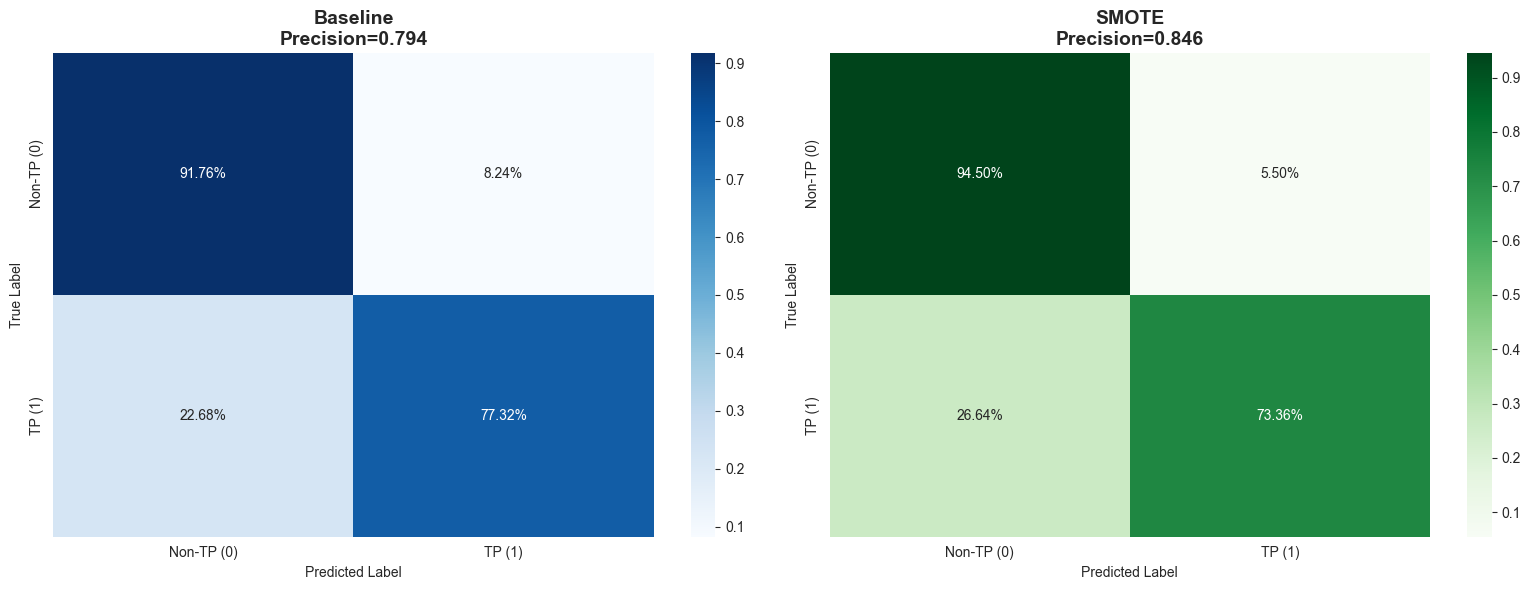

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_baseline_norm = cm_baseline.astype('float') / cm_baseline.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_baseline_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Non-TP (0)', 'TP (1)'],
            yticklabels=['Non-TP (0)', 'TP (1)'],
            ax=axes[0])
axes[0].set_title(f'Baseline\nPrecision={precision_baseline:.3f}', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# SMOTE
cm_smote = confusion_matrix(y_test, y_pred_smote)
cm_smote_norm = cm_smote.astype('float') / cm_smote.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_smote_norm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['Non-TP (0)', 'TP (1)'],
            yticklabels=['Non-TP (0)', 'TP (1)'],
            ax=axes[1])
axes[1].set_title(f'SMOTE\nPrecision={precision_smote:.3f}', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 10. ROC Curves Comparison

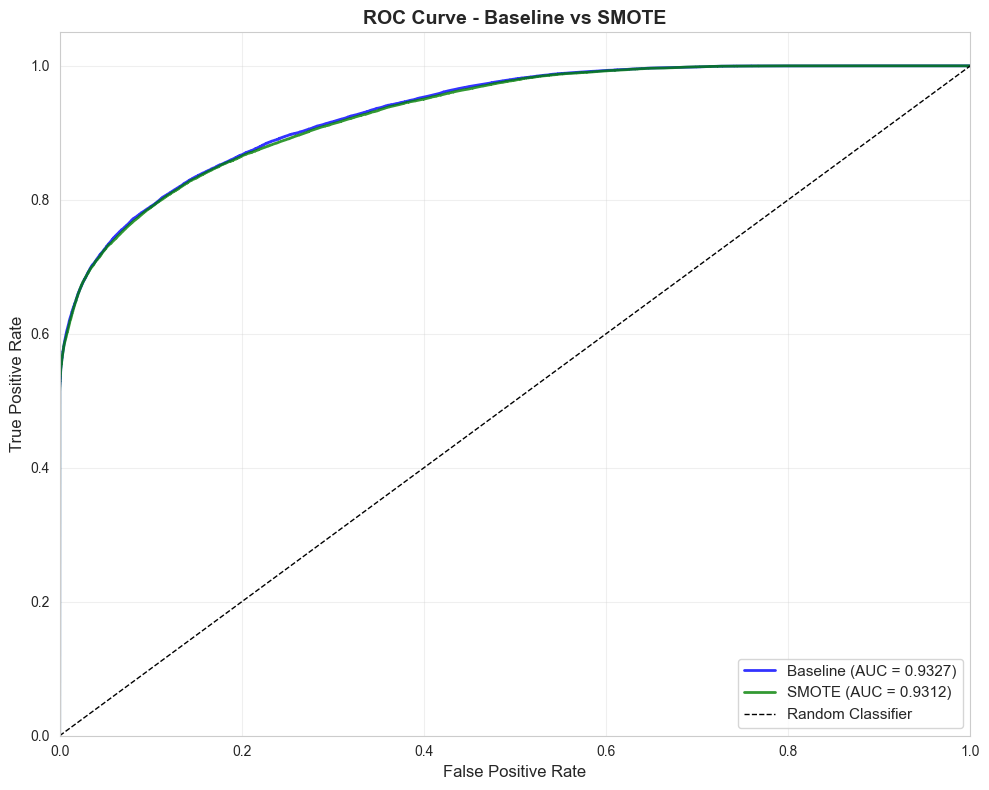

In [48]:
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)

plt.figure(figsize=(10, 8))

plt.plot(fpr_baseline, tpr_baseline, color='blue', lw=2, alpha=0.8,
         label=f'Baseline (AUC = {roc_auc_baseline:.4f})')
plt.plot(fpr_smote, tpr_smote, color='green', lw=2, alpha=0.8,
         label=f'SMOTE (AUC = {roc_auc_smote:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Baseline vs SMOTE', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Feature Importance (SMOTE Model)

Top 20 Features più importanti (SMOTE model):
                      Feature  Importance
       ResourceType_freq_mean    0.422364
      ActionGrouped_freq_mean    0.159411
     ActionGranular_freq_mean    0.126163
       ThreatFamily_freq_mean    0.105520
             SmoothedRisk_avg    0.046945
                    T1078_sum    0.035482
        LastVerdict_freq_mean    0.011511
              GeoLoc_freq_avg    0.010636
              Roles_freq_mean    0.010156
     EvidenceRole_Related_sum    0.006627
         EntityType_freq_mean    0.005422
           Category_freq_mean    0.005087
   SuspicionLevel_Missing_sum    0.004681
             Duration_seconds    0.003709
  AntispamDirection_freq_mean    0.003696
                    T1046_sum    0.003101
                 NumEvidences    0.002893
                    T1106_sum    0.002649
SuspicionLevel_Suspicious_sum    0.002633
                    T1566_sum    0.002276


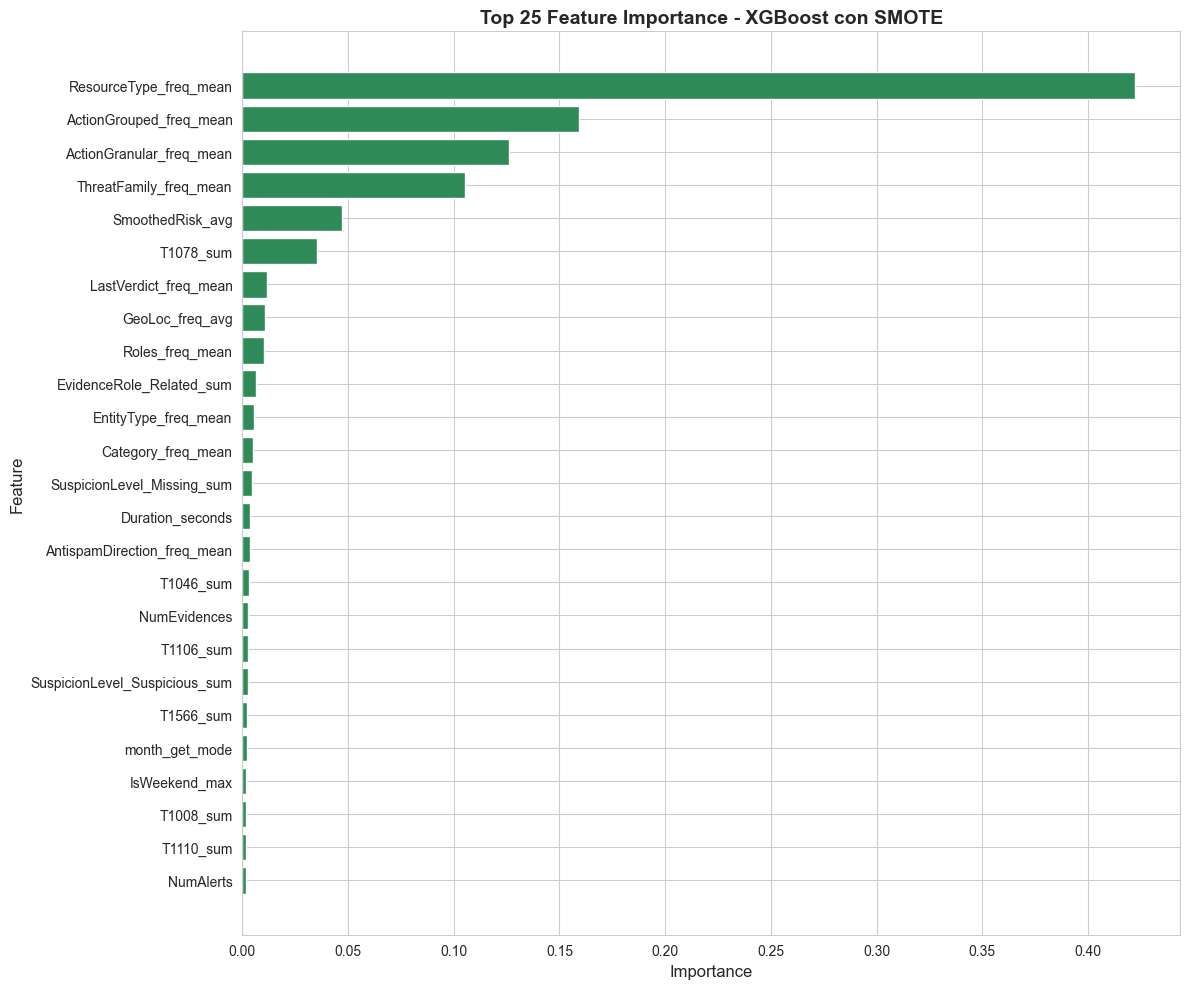

In [49]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_smote.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Features più importanti (SMOTE model):")
print(feature_importance.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(12, 10))
top_n = 25
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['Importance'], color='seagreen')
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importance - XGBoost con SMOTE', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Summary

**SMOTE (Synthetic Minority Oversampling Technique):**
- Genera sample sintetici interpolando tra k-nearest neighbors della classe minoritaria
- Bilancia completamente il training set (50/50)
- Aumenta dimensione training set (~2x)

**Vantaggi:**
- ✅ Migliora recall per classe minoritaria
- ✅ Riduce bias verso classe maggioritaria
- ✅ Più robusto di semplice oversampling random

**Svantaggi:**
- ⚠️ Può generare sample irrealistici se classi si sovrappongono
- ⚠️ Rischio di overfitting su sample sintetici
- ⚠️ Computazionalmente più costoso (più sample)

**Quando usare SMOTE:**
- Dataset piccolo-medio (<1M samples)
- Classe minoritaria ben separata
- Recall critico per classe minoritaria

**Alternative:**
- **ADASYN** - Variante adattiva di SMOTE
- **BorderlineSMOTE** - Genera sample solo al confine decisionale
- **SMOTE + Tomek** - SMOTE + pulizia dei boundary confusi

In [50]:
import os
import json
from datetime import datetime

# Crea directory per il modello
model_dir = '../models/xgboost_smote'
os.makedirs(model_dir, exist_ok=True)

# Salva modello SMOTE
model_smote.save_model(f'{model_dir}/model.json')
print(f"✅ Modello SMOTE salvato: {model_dir}/model.json")

# Salva feature importance
feature_importance.to_csv(f'{model_dir}/feature_importance.csv', index=False)
print(f"✅ Feature importance salvato: {model_dir}/feature_importance.csv")

# Salva metriche complete
metrics = {
    "model_name": "XGBoost_SMOTE",
    "timestamp": datetime.now().isoformat(),
    "dataset_version": "processed_v3",
    "class_balancing": "SMOTE (Synthetic Minority Oversampling)",
    "baseline_comparison": {
        "baseline_precision": float(precision_baseline),
        "baseline_recall": float(recall_baseline),
        "baseline_f1": float(f1_baseline),
        "baseline_roc_auc": float(roc_auc_baseline)
    },
    "smote_metrics": {
        "precision": float(precision_smote),
        "recall": float(recall_smote),
        "f1_score": float(f1_smote),
        "roc_auc": float(roc_auc_smote),
        "improvement_vs_baseline": {
            "precision": float(precision_smote - precision_baseline),
            "recall": float(recall_smote - recall_baseline),
            "f1_score": float(f1_smote - f1_baseline),
            "roc_auc": float(roc_auc_smote - roc_auc_baseline)
        }
    },
    "training_data": {
        "original_train_samples": len(X_train),
        "smote_train_samples": len(X_train_smote),
        "increase_percentage": float((len(X_train_smote) - len(X_train)) / len(X_train) * 100),
        "class_distribution_before": {
            "class_0": int((y_train == 0).sum()),
            "class_1": int((y_train == 1).sum())
        },
        "class_distribution_after": {
            "class_0": int((y_train_smote == 0).sum()),
            "class_1": int((y_train_smote == 1).sum())
        }
    },
    "n_features": X_train.shape[1],
    "n_test_samples": len(X_test),
    "hyperparameters": {
        "objective": "binary:logistic",
        "max_depth": 6,
        "learning_rate": 0.1,
        "n_estimators": 200,
        "subsample": 0.8,
        "colsample_bytree": 0.8
    },
    "top_10_features": feature_importance.head(10).to_dict('records')
}

with open(f'{model_dir}/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Metriche salvate: {model_dir}/metrics.json")

print(f"\n{'='*60}")
print("RIEPILOGO SALVATAGGIO")
print(f"{'='*60}")
print(f"Directory: {model_dir}")
print(f"  - model.json")
print(f"  - feature_importance.csv")
print(f"  - metrics.json")
print(f"{'='*60}")

✅ Modello SMOTE salvato: ../models/xgboost_smote/model.json
✅ Feature importance salvato: ../models/xgboost_smote/feature_importance.csv
✅ Metriche salvate: ../models/xgboost_smote/metrics.json

RIEPILOGO SALVATAGGIO
Directory: ../models/xgboost_smote
  - model.json
  - feature_importance.csv
  - metrics.json


## 12. Salvataggio Modello e Metriche